In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy import interpolate

In [3]:
# Agrega el directorio superior al path
sys.path.append(os.path.abspath('..'))

In [4]:
import stars.EDOs.Sistemas as eds
import stars.Utilez as eu

In [5]:
eu.plots.general()

#### Consideremos un EoS polítropa de la forma $p=k \rho^{\Gamma}$

Como nos enfocaremos en objetos cuya masa se encuentra en el rango $M\sim 1-20\, \textup{M}_\odot$ y sus radios se encuentran entre $R\sim 9-10^{5}$ km definiremos por conveniencia la escala de energía como $m_*=\sqrt{\frac{\text{Mp}^3}{M_\odot}}$. Esto garantiza que la masa obtenida sea equivalente a su valor en $M_\odot$. 

Consideremos los siguientes datos típicos de una estrella de neutrones  [Ref. Neutron Stars for Undergraduates](https://arxiv.org/pdf/nucl-th/0309041)

| Presión | Densidad  | Valor de K |
| --- | --- | --- |
| $1.6\times 10^{33}$ dyne/$cm^2$| $2.8\times 10^{14}$ g/$cm^3$ | ? |


Sus radios suelen oscilar alrededor de los $12$ km, y masas entre $1-2$ masas solares.

Usando estos datos intentemos contruir el perfil de la estrella de neutrones asociada Para ello seguimos la siguiente *receta*:

- Definir el valor de $m_*$, en particular usaremos $m_*=\sqrt{Mp^3/M_\odot}$

- Obtener las cantidades adimensionales $\epsilon, p$

- A partir de estas encontramos el valor de la $K$ que nos permite recuperar la $\epsilon$ dado $p$, para ello la despejamos de la expresión
$$
\epsilon = \left(\frac{p}{K}\right)^{1/\Gamma} + \frac{p}{\Gamma-1}
$$

lo que nos da:

$$
K = p\left(\frac{p}{1-\Gamma}+\epsilon\right)^{-\Gamma}
$$

IMPORTANTE: en dado caso que tengamos la $k$ fisica, pues solo debemos convertirla a barra mediante
$$
K = k \left(\frac{m_{*}^{4}}{8\pi}\right)^{\Gamma-1}
$$

UNIDADES: como vimos, para una ecuación de estado de la forma politrópica señalada tendremos que $[k]=[p]^{1-\Gamma}$. Usando el resultado anterior tendremos que (tarea: comprobar)
$$
k = K \left(\frac{m_{*}^{4}}{8\pi}\frac{c^5}{\hbar^3}\right)^{1-\Gamma}
$$



In [6]:
# factores de conversión
# recordar: dyne = 1e-5 Newton
facDyneCmSqtoNm = 1e-01  # 1e-5/1e-4
facGramCm3toKgmet = 1e03  # 1e-03/1e-06

# constantes universales
c = 299792458  # m/s
hb = 1.054571817e-34  # kg m^2/s
Mp = 2.17645e-08  # kg

# datos del Sol
Ms = 1.9884e30  # kg
Rs = 6.957e+8 # m

In [7]:
# Definiendo escala de energía m_*
ms = np.sqrt(Mp**3/Ms)  # [kg]

# convirtiendo a unidades de código
pf = 1.6e33  # dyne/cm^2
p = pf*(hb**3/c**5)*(8*np.pi/ms**4)*facDyneCmSqtoNm

epf = 2.8e14 # g/cm^3
ep = epf*(hb/c)**3*(8*np.pi/ms**4)*facGramCm3toKgmet

print('Valor de la densidad total de energía adimensional:', ep)
print('Valor de la presion central adimensional:', p)

# Definiendo el polítropo y calculando K
Gam = 2
fK = lambda p, ep, Gam: p/(ep+p/(1-Gam))**Gam
Kval = fK(p, ep, Gam)
print('El valor de K es:', Kval, '. En unidades físicas es', Kval*(ms**4*c**5/(8*np.pi*hb**3))**(1-Gam), r'Pa^%2.1f'%(1-Gam))

# alternativa
#f = lambda k: k-(p/(ep+p/(1-Gam))**Gam)
#eu.roo_Secv1(f, [0, 1])

Valor de la densidad total de energía adimensional: 0.011394088981542134
Valor de la presion central adimensional: 7.244362139424441e-05
El valor de K es: 0.5651725474766963 . En unidades físicas es 2.5589466282389003e-37 Pa^-1.0


Obtengamos la solución numérica y grafiquemos la estrella obtenida

In [8]:
epsilon = lambda p, K, G: (p/K)**(1/G) + p/(G-1)

fepsilon = lambda p: epsilon(p, Kval, Gam)

rmin, rmax = 0, 20
arg = [fepsilon]
p0 = p
in0 = [1, 1, p0]  # [g0, n0, Phi0, Phi'0]
npt = 5800
data = [in0, rmin, rmax, npt]

xval, yval = eu.rk.RKMet(eds.systemNS, data, arg=arg, rk='rk5')

# alternativa scipy
# rspan = np.linspace(rmin, rmax, npt)
# met = 'RK45'
# Rtol = 1e-09
# Atol = 1e-10
# sol2 = solve_ivp(eds.systemNS, [rmin, rmax], in0, t_eval=rspan, args=(arg,), method=met, rtol=Rtol, atol=Atol)

A continuación mostramos los plots en las unidades físicas

- el perfil de la presion central (panel izquierdo). NOTEMOS que si quisieramos graficar la densidad, solo tendríamos que usar la ecuación que las relaciona,
- el perfil de la masa (panel central),
- los perfiles métricos y su escalamiento (panel derecho).

RECORDEMOS que
$$
r=\frac{\text{Mp}}{m_*^2} x,\quad p=\frac{m_*^4}{8 \pi }\bar{p}, \quad M=\frac{\text{Mp}^3}{m_*^2}\bar{M}
$$

donde
$\bar{M}=\frac{1}{2} x \left(1-\frac{1}{g(x)^2}\right)$

llevandolo a unidades físicas tendremos (tarea: verificar)
$$
r=\frac{\text{Mp}}{m_*^2}\frac{\hbar}{c}\frac{1}{10^3} x,\quad p=\frac{m_*^4}{8 \pi }\frac{c^5}{\hbar^3}\bar{p},\quad \epsilon=\frac{m_*^4}{8 \pi }\frac{c^3}{\hbar^3}\bar{\epsilon}, \quad M=\frac{\text{Mp}^3}{m_*^2}\frac{1}{M_\odot}\bar{M}
$$

donde expresaremos el radio en kilometros km, la presión en pascal Pa y la masa en masas solares $M_\odot$.

In [9]:
# conversiones
pFac = ms**4*c**5/(8*np.pi*hb**3)
mFac = Mp**3/ms**2/Ms
rFac = Mp*hb/(ms**2*c)/1e03
epFac = (hb**3/c**3)*(8*np.pi/ms**4)

In [11]:
# densidad de energia
dens = lambda p, K, Gam: (p/K)**(1/Gam)+p/(Gam-1)

ind = yval[:, 2]==yval[-1, 2]  # cambiando a 0
yval[ind, 2] = 0

epVal = dens(yval[:, 2],  Kval, Gam)/epFac/facGramCm3toKgmet  # [g/cm^3]
rval = xval*rFac  # km

La constante de escalamiento es:  0.9750917154257441 



/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_35190/2822408087.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5))
/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_35190/2822408087.py:20: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax0 = fig.add_axes((left_0, bottom_0, width_0, height_0))
/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_35190/2822408087.py:70: RuntimeWarning: invalid value encountered in sqrt
  g00Sc = lambda r, masa: np.sqrt(1-2*masa/r)


Text(0.5, 0, '$r \\,[km]$')

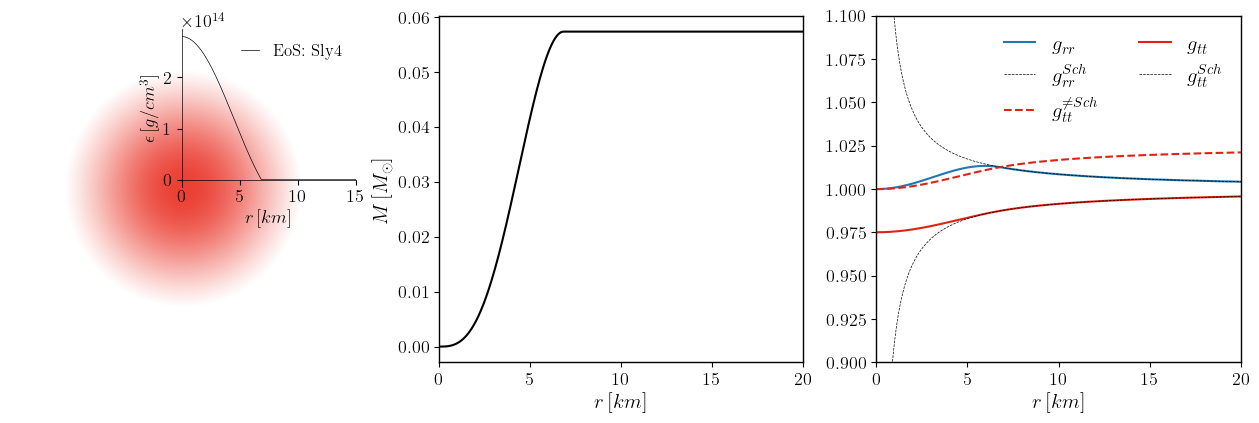

In [12]:
fR = interpolate.interp1d(rval, epVal)  # interpolamos el perfil

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5))

# dibujando circulo difuminado
rad = 10
xy0 = [0, 0]
eu.plots.circlef(ax[0], xy0, fR, rad, halo_color='#eb4034', colf='white', npt=600, orig=False)

# Editando spines y limites
ax[0].set_xlim(-rad, rad)
ax[0].set_ylim(-rad, rad)

ax[0].spines[['top', 'bottom', 'left', 'right']].set_visible(False)
ax[0].set_xticks([])
ax[0].set_yticks([])

# insert plot
left_0, bottom_0, width_0, height_0 = 0.238, 0.5, 0.109, 0.35
ax0 = fig.add_axes((left_0, bottom_0, width_0, height_0))
ax0.patch.set_alpha(0)  # poniendolo transparente

ax0.plot(rval, epVal, lw=.5, color='#00060f', label=r'EoS: Poly')

# Editando spines y limites
ax0.patch.set_facecolor('none')
ax0.spines[['top', 'right']].set_visible(False)
ax0.spines[['left', 'bottom']].set_position(('data', 0))
#ax0.spines['bottom'].set_bounds(low=0, high=12)

ax0.set_xlim(0, 15)
# añadiendo label
ax0.set_xlabel(r'$r \,[km]$', fontsize='small')
ax0.set_ylabel(r'$\epsilon \,[g/cm^3]$', fontsize='small')

# change all spines
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(0.5)

ax0.legend(loc='upper right', 
           frameon=False,
           fontsize=12,
           handlelength=1.1,
           labelspacing=0.2)

##########
mas = lambda r, g: r*(1-1/g**2)/2
ax[1].plot(rval, mas(xval, yval[:, 0])*mFac, c='k', lw=1.5, label=r'$M(r)$')

ax[1].set_xlim(0, 20)
ax[1].set_ylabel(r'$M\, [M_\odot]$')
ax[1].set_xlabel(r'$r \,[km]$')


##########
Nmax = yval[-1, 1]
gmax = yval[-1, 0]
c = eu.tools.escalamiento(Nmax, gmax)  # constante de escalamiento

print('La constante de escalamiento es: ', c,  '\n')

# Identificando el radio de Sch
masa = mas(xval, yval[:, 0])[-1]  # masa
rSch = 2*masa  # radio de Sch
_, idx = eu.tools.find_nearest(xval, rSch)
xvalSch = xval[idx:]
rvalSch = xvalSch*rFac # km

# Sch g00 (recordar q N^2)
g00Sc = lambda r, masa: np.sqrt(1-2*masa/r)

## g_{rr} = gg
ax[2].plot(rval, yval[:, 0], lw=1.5, label=r'$g_{rr}$')
ax[2].plot(rvalSch, 1/g00Sc(xvalSch, masa), c='k', ls='--', lw=0.5, label=r'$g^{Sch}_{rr}$')

## g_{tt} = NN
ax[2].plot(rval, yval[:, 1], lw=1.5, c='#e02214', ls='--',label=r'$g^{\neq Sch}_{tt}$')
ax[2].plot(rval, yval[:, 1]*c, lw=1.5, c='#e02214', label=r'$g_{tt}$')
ax[2].plot(rvalSch, g00Sc(xvalSch, masa), c='k', ls='--', lw=0.5, label=r'$g^{Sch}_{tt}$')

ax[2].set_ylim(0.9, 1.1)
ax[2].set_xlim(0, 20)
ax[2].legend(frameon=False, ncol=2)
ax[2].set_xlabel(r'$r \,[km]$')

#### Veamos un ejemplo de resolución del sistema EDO usando una EoS realista

In [6]:
# epsilon[g/cm^3], P[dyn/cm^2]
_, _, epSly4, pSly4 = np.loadtxt('/Users/armandoroqueestrada/Library/Mobile Documents/com~apple~CloudDocs/GitHub/GR_NS_BS/EoS/sly4.dat', unpack=True)

In [7]:
# factores de conversión
# recordar: dyne = 1e-5 Newton
facDyneCmSqtoNm = 1e-01  # 1e-5/1e-4
facGramCm3toKgmet = 1e03  # 1e-03/1e-06

# constantes universales
c = 299792458  # m/s
hb = 1.054571817e-34  # kg m^2/s
Mp = 2.17645e-08  # kg

# datos del Sol
Ms = 1.9884e30  # kg
Rs = 6.957e+8 # m

In [8]:
# Definiendo escala de energía m_*
ms = np.sqrt(Mp**3/Ms)  # [kg]

# convirtiendo a adimensionales
pFac = (hb**3/c**5)*(8*np.pi/ms**4)
epFac = (hb**3/c**3)*(8*np.pi/ms**4)

pdata = pSly4*facDyneCmSqtoNm*pFac
epdata = epSly4*facGramCm3toKgmet*epFac

# interpolando
epsilon = interpolate.interp1d(pdata, epdata, kind='quadratic')

In [9]:
# RESOLVIENDO
pf = 1.6e33  # dyne/cm^2
p = pf*(hb**3/c**5)*(8*np.pi/ms**4)*facDyneCmSqtoNm

rmin, rmax = 0, 19
arg = [epsilon]
p0 = p
in0 = [1, 1, p0]  # [g0, n0, Phi0, Phi'0]
npt = 3800
data = [in0, rmin, rmax, npt]

xval, yval = eu.rk.RKMet(eds.systemNS, data, arg=arg, rk='rk5')

In [10]:
# conversiones
mFac = Mp**3/ms**2/Ms
rFac = Mp*hb/(ms**2*c)/1e03 #

epVal = epsilon(yval[:, 2])/epFac/facGramCm3toKgmet  # [g/cm^3]
rval = xval*rFac  # km

La constante de escalamiento es:  0.9666122837482903 



/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_35317/3010245268.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5))
/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_35317/3010245268.py:21: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax0 = fig.add_axes((left_0, bottom_0, width_0, height_0))
/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_35317/3010245268.py:71: RuntimeWarning: invalid value encountered in sqrt
  g00Sc = lambda r, masa: np.sqrt(1-2*masa/r)


Text(0.5, 0, '$r \\,[km]$')

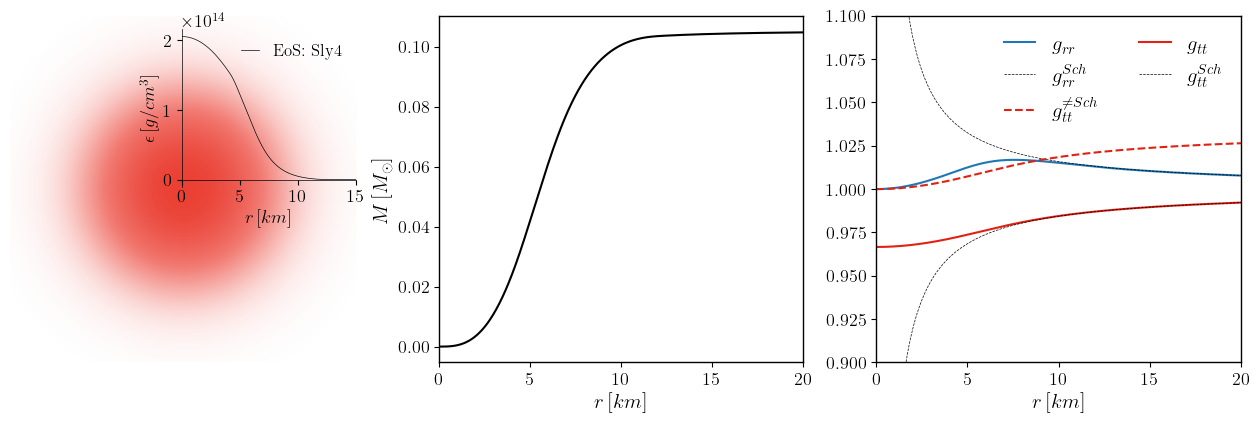

In [11]:
# GRAFICANDO
fR = interpolate.interp1d(rval, epVal)  # interpolamos el perfil

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5))

# dibujando circulo difuminado
rad = 10
xy0 = [0, 0]
eu.plots.circlef(ax[0], xy0, fR, rad, halo_color='#eb4034', colf='white', npt=600, orig=False)

# Editando spines y limites
ax[0].set_xlim(-rad, rad)
ax[0].set_ylim(-rad, rad)

ax[0].spines[['top', 'bottom', 'left', 'right']].set_visible(False)
ax[0].set_xticks([])
ax[0].set_yticks([])

# insert plot
left_0, bottom_0, width_0, height_0 = 0.238, 0.5, 0.109, 0.35
ax0 = fig.add_axes((left_0, bottom_0, width_0, height_0))
ax0.patch.set_alpha(0)  # poniendolo transparente

ax0.plot(rval, epVal, lw=.5, color='#00060f', label=r'EoS: Sly4')

# Editando spines y limites
ax0.patch.set_facecolor('none')
ax0.spines[['top', 'right']].set_visible(False)
ax0.spines[['left', 'bottom']].set_position(('data', 0))
#ax0.spines['bottom'].set_bounds(low=0, high=12)

ax0.set_xlim(0, 15)
# añadiendo label
ax0.set_xlabel(r'$r \,[km]$', fontsize='small')
ax0.set_ylabel(r'$\epsilon \,[g/cm^3]$', fontsize='small')

# change all spines
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(0.5)

ax0.legend(loc='upper right', 
           frameon=False,
           fontsize=12,
           handlelength=1.1,
           labelspacing=0.2)

##########
mas = lambda r, g: r*(1-1/g**2)/2
ax[1].plot(rval, mas(xval, yval[:, 0])*mFac, c='k', lw=1.5, label=r'$M(r)$')

ax[1].set_xlim(0, 20)
ax[1].set_ylabel(r'$M\, [M_\odot]$')
ax[1].set_xlabel(r'$r \,[km]$')


##########
Nmax = yval[-1, 1]
gmax = yval[-1, 0]
c = eu.tools.escalamiento(Nmax, gmax)  # constante de escalamiento

print('La constante de escalamiento es: ', c,  '\n')

# Identificando el radio de Sch
masa = mas(xval, yval[:, 0])[-1]  # masa
rSch = 2*masa  # radio de Sch
_, idx = eu.tools.find_nearest(xval, rSch)
xvalSch = xval[idx:]
rvalSch = xvalSch*rFac # km

# Sch g00 (recordar q N^2)
g00Sc = lambda r, masa: np.sqrt(1-2*masa/r)

## g_{rr} = gg
ax[2].plot(rval, yval[:, 0], lw=1.5, label=r'$g_{rr}$')
ax[2].plot(rvalSch, 1/g00Sc(xvalSch, masa), c='k', ls='--', lw=0.5, label=r'$g^{Sch}_{rr}$')

## g_{tt} = NN
ax[2].plot(rval, yval[:, 1], lw=1.5, c='#e02214', ls='--',label=r'$g^{\neq Sch}_{tt}$')
ax[2].plot(rval, yval[:, 1]*c, lw=1.5, c='#e02214', label=r'$g_{tt}$')
ax[2].plot(rvalSch, g00Sc(xvalSch, masa), c='k', ls='--', lw=0.5, label=r'$g^{Sch}_{tt}$')

ax[2].set_ylim(0.9, 1.1)
ax[2].set_xlim(0, 20)
ax[2].legend(frameon=False, ncol=2)
ax[2].set_xlabel(r'$r \,[km]$')

### Construyamos familia de soluciones

Consideremos la ecuación realista y un conjunto de valores para la presión central que satisfagan la inecuación:
$$
{T^{\mu}}_{\mu} = \rho-3p>0
$$

In [9]:
# Definiendo escala de energía m_*
ms = np.sqrt(Mp**3/Ms)  # [kg]

# convirtiendo a adimensionales
pFac = (hb**3/c**5)*(8*np.pi/ms**4)
epFac = (hb**3/c**3)*(8*np.pi/ms**4)

pdata = pSly4*facDyneCmSqtoNm*pFac
epdata = epSly4*facGramCm3toKgmet*epFac

# interpolando
epsilon = interpolate.interp1d(pdata, epdata, kind='quadratic')

In [61]:
# RESOLVIENDO
#pfv = np.linspace(1e+27, 1e+36, 100)  #  [dyn/cm^2]
pinf = 1e+27 # [dyn/cm^2]
psup = 1e+36 # [dyn/cm^2]

pval = np.arange(pinf*facDyneCmSqtoNm*pFac, psup*facDyneCmSqtoNm*pFac, 0.0001) 

#pval = [i*facDyneCmSqtoNm*pFac for i in pfv]

dataprof = []
for i in pval:
    rmin, rmax = 0, 2000
    arg = [epsilon]
    p0 = i
    in0 = [1, 1, p0]  # [g0, n0, Phi0, Phi'0]
    npt = 30000
    data = [in0, rmin, rmax, npt]

    #xval, yval = eu.rk.RKMet(eds.systemNS, data, arg=arg, rk='rk5')
    #plt.plot(xval, yval[:, 2], c='k', lw=1.)

    # alternativa scipy
    rspan = np.linspace(rmin, rmax, npt)
    met = 'RK45'
    Rtol = 1e-09
    Atol = 1e-10
    
    sol2 = solve_ivp(eds.systemNS, [rmin, rmax], in0, t_eval=rspan, args=(arg,), method=met, rtol=Rtol, atol=Atol)
    #dataprof.append([xval, yval])
    dataprof.append([sol2.t, sol2.y])

In [27]:
# conversiones
mFac = Mp**3/ms**2/Ms
rFac = Mp*hb/(ms**2*c)/1e03 #

#epVal = epsilon(yval[:, 2])/epFac/facGramCm3toKgmet  # [g/cm^3]
#rval = xval*rFac  # km

/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_35655/151991318.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))


(0.0, 15.0)

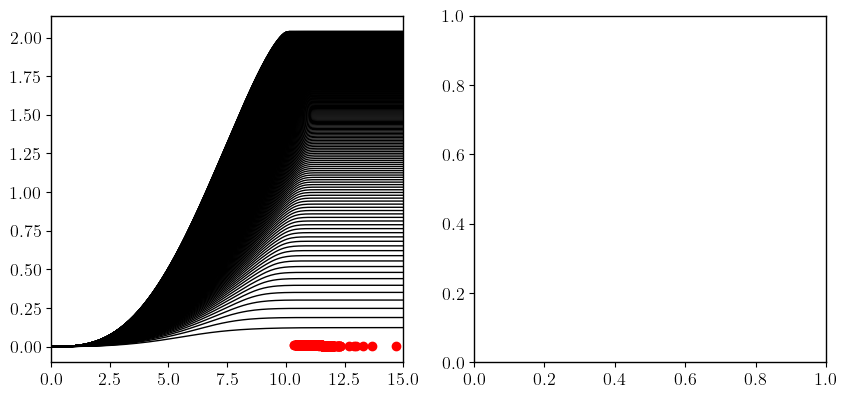

In [68]:
mas = lambda r, g: r*(1-1/g**2)/2
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))

for xval, yval in dataprof[1:]:
    #ax[0].plot(xval*rFac, mas(xval, yval[:, 0])*mFac, c='k', lw=1.)    
    ax[0].plot(xval*rFac, mas(xval, yval[0])*mFac, c='k', lw=1.)    
    
    ind = sum(yval[2]==yval[2][-1])
    #print(xval[-ind])
    ax[0].plot(xval[-ind]*rFac, mas(xval[-ind], yval[0][-1])*mFac, c='r', marker='o', lw=1.)


ax[0].set_xlim(0, 15)

### Límite de Buchdahl

### Límite no relativista